# EIT - Digitale tvillinger - Gruppe 5
# Nevralt nettverk for gjennkjenning av kumlokk


### Installing Requirements

In [22]:
!pip install matplotlib numpy albumentations tensorflow

  Using cached tensorflow-2.12.0-cp310-cp310-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.12.0-cp310-cp310-win_amd64.whl (272.8 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorboard-2.12.2-py3-none-any.whl (5.6 MB)
  Using cached grpcio-1.54.0-cp310-cp310-win_amd64.whl (4.1 MB)
  Using cached h5py-3.8.0-cp310-cp310-win_amd64.whl (2.6 MB)
  Using cached jax-0.4.8-py3-none-any.whl
  Using cached ml_dtypes-0.1.0-cp310-cp310-win_amd64.whl (120 kB)
  Using cached google_auth-2.17.3-py2.py3-none-any.whl (178 kB)
  Using cached Markdown-3.4.3-py3-none-any.whl (93 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Using cached cachetools-5.3.0

### Importing dependencies

In [254]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os
import albumentations as alb
import cv2

### Laste ut filer til datastream

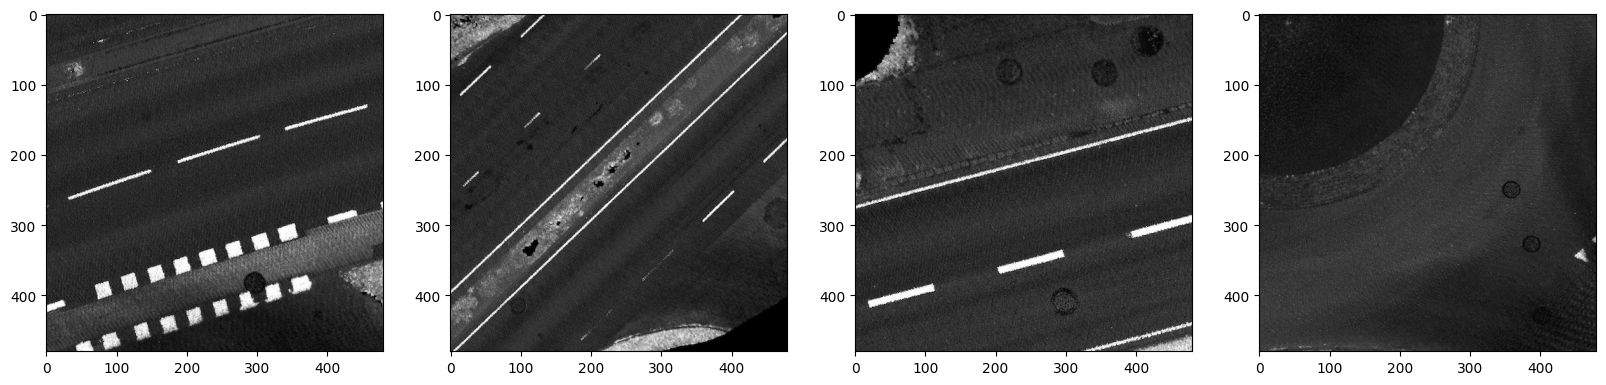

In [247]:
images = tf.data.Dataset.list_files('data\\all\\images\\*.jpeg')


def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img, channels=1)
    return img

images = images.map(load_image)


image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
plot_images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image, cmap='gray')
plt.show()

### Kjører på med 70% train (59), 15% test (13), 15% val (12).

In [250]:
for folder in ['train','test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'all', 'labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

### Lager en image augmentor. Kjører på med randoom cropping, litt brigtness endringer, gamma endringer og speiling

In [386]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomGamma(p=0.2),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.VerticalFlip(p=0.5)], 
                       keypoint_params=alb.KeypointParams(format='xy', 
                                                  label_fields=['class_labels']))

In [379]:
img = cv2.imread(os.path.join('data','train', 'images','Rogaland_TrueRoad_000418.jpeg'))

with open(os.path.join('data', 'train', 'labels', 'Rogaland_TrueRoad_000418.json'), 'r') as f:
    label = json.load(f)
    
label['shapes'][0]['points']

[[212.02166064981947, 311.84115523465704],
 [225.01805054151623, 324.8375451263538]]

### Fikser label coordinater, så de er relative til oppløsningen

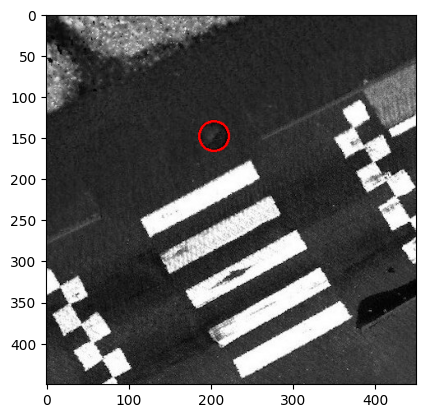

In [406]:
coords = [(0, 0), (0, 0)]
coords[0] = (int(label['shapes'][0]['points'][0][0]), int(label['shapes'][0]['points'][0][1]))
coords[1] = (int(label['shapes'][0]['points'][1][0]), int(label['shapes'][0]['points'][1][1]))

def get_radius_from_points(center, edge):
    return np.sqrt((center[0] - edge[0])**2 + (center[1] - edge[1])**2)

augmented = augmentor(image=img, keypoints=coords, class_labels=["Center", "Edge"])

cv2.circle(augmented['image'], 
              augmented['keypoints'][0],
              int(get_radius_from_points(augmented['keypoints'][0],
              augmented['keypoints'][1])), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### Run augmentation for all data.